In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

In [2]:
import numpy as np

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from fairness.utils import *
from fairness.mixture import *

In [5]:
%matplotlib inline

In [600]:
n, d = 10000, 2

Σ0 = np.random.rand(d) * np.eye(d, d) 

Σ1 = 2*np.random.rand(d) * np.eye(d, d) 

μ00 = np.ones((d, 1))
μ00[0] = -3
μ01 = np.zeros((d, 1))
μ01[0] = -3
μ11 = np.zeros((d, 1)) 
μ11[0] = -1.5
μ10 = np.zeros((d, 1))


In [623]:
p1, p0, p = .1, .5, .5


We simulate a Gaussian mixture model with the following: 

        S ~ B(p)
        Y | S = 1 ~ B(p1)
        Y | S = 0 ~ B(p0)

        X | Y = 1, S = 1 ~ N(μ11, Σ1)
        X | Y = 1, S = 0 ~ N(μ10, Σ0)
        X | Y = 0, S = 1 ~ N(μ01, Σ1)
        X | Y = 0, S = 0 ~ N(μ00, Σ0)

In [624]:
X, S, y = simulate(n, d, p, p0,  p1, μ00, μ01, μ10, μ11, Σ0 , Σ1)

We display the true unfairness of the synthetic data as a function of the probabilities of having a positive outcome while being part of the sensitive and non-sensitive group.

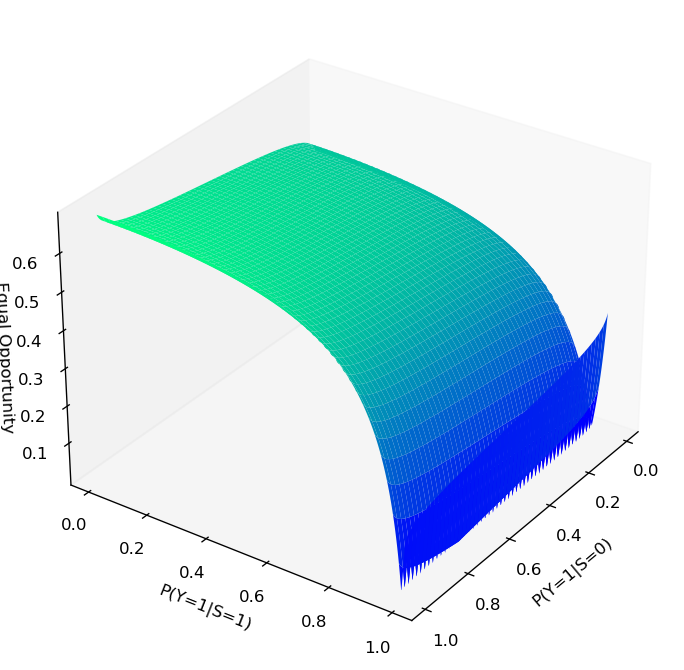

In [625]:
p0_span = np.linspace(.01, .99, 1000)
p1_span = np.linspace(.01, .99, 1000)

px, py = np.meshgrid(p0_span, p1_span)

fig = plt.figure(dpi=120, figsize=[7,7])
ax = plt.axes(projection='3d')
ax.grid(False)
ax.view_init(30, 35)
ax.zaxis.labelpad=-0.7
ax.plot_surface(px, py, unfairness(np.ravel(px), np.ravel(py), μ00, μ01, μ10, μ11, Σ0, Σ1).reshape(1000, 1000), cmap='winter');
ax.set_xlabel('P(Y=1|S=0)');
ax.set_ylabel('P(Y=1|S=1)');
ax.set_zlabel('Equal Opportunity');


In [626]:
print(f'The fairness for this toy model is: {unfairness(p0, p1, μ00, μ01, μ10, μ11, Σ0, Σ1).item():.3f}')

The fairness for this toy model is: 0.596


In [627]:
import matplotlib.pyplot as plt
%matplotlib inline

In [628]:
def plot(X, y, S):
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot()
    s_mask = S == 1
    y_mask = y == 1
    
    ax.scatter(X[s_mask & y_mask, 0], X[s_mask & y_mask, 1], c='green', marker='_', s=33, label='S=1 & Y=1');
    ax.scatter(X[~s_mask & y_mask, 0], X[~s_mask & y_mask, 1], c='purple', alpha=.5, marker='+', s=33, label='S=0 & Y=1');
    ax.scatter(X[s_mask & ~y_mask, 0], X[s_mask & ~y_mask, 1], c='orange', marker='x', s=33, label='S=1 & Y=0');
    ax.scatter(X[~s_mask & ~y_mask, 0], X[~s_mask & ~y_mask, 1], c='red', marker='*', s=33, label='S=0 & Y=0');
    fig.legend(ncol=2, bbox_to_anchor=[.99, 1.15])
    fig.tight_layout()

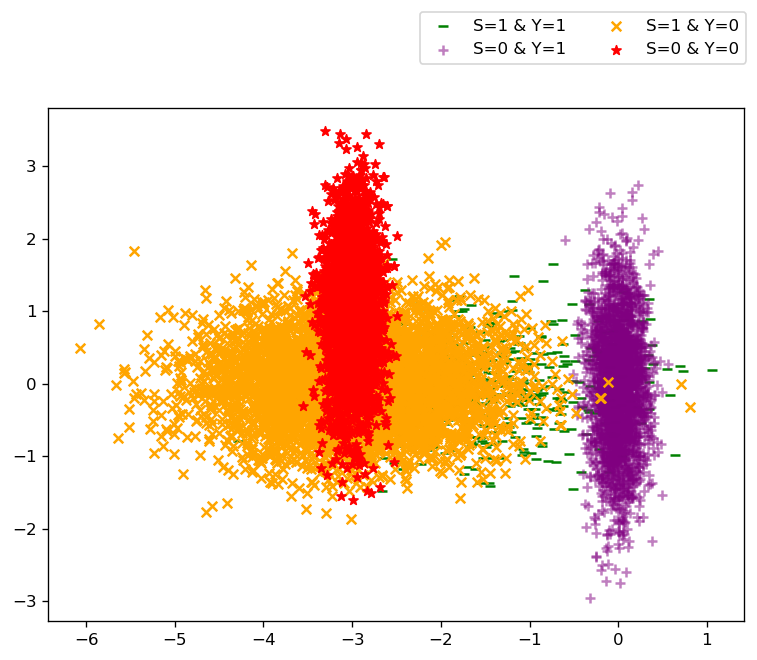

In [629]:
plot(X, y, S)

In [630]:
Xt, St, yt = simulate(n, d, p, p0,  p1, μ00, μ01, μ10, μ11, Σ0 , Σ1)

ACC = 0.9618   |   DEO = 0.5237113402061856


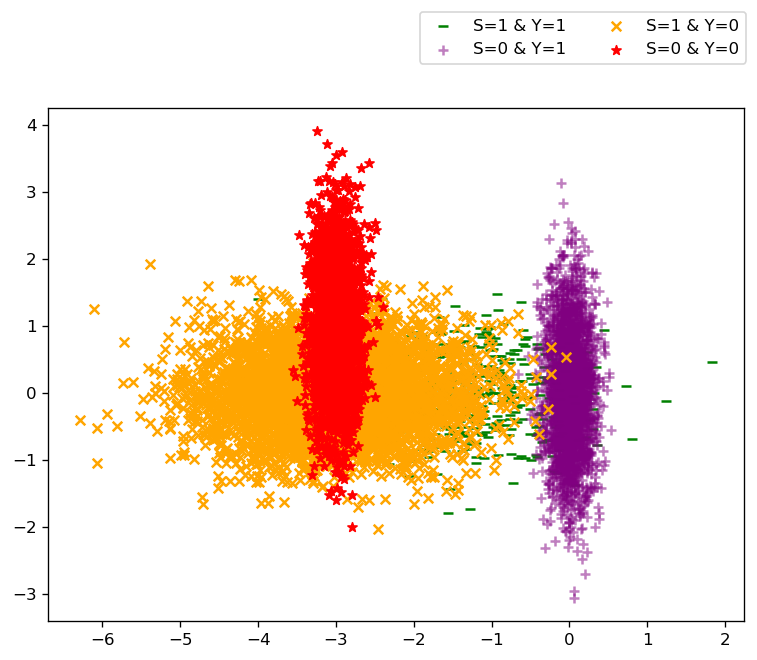

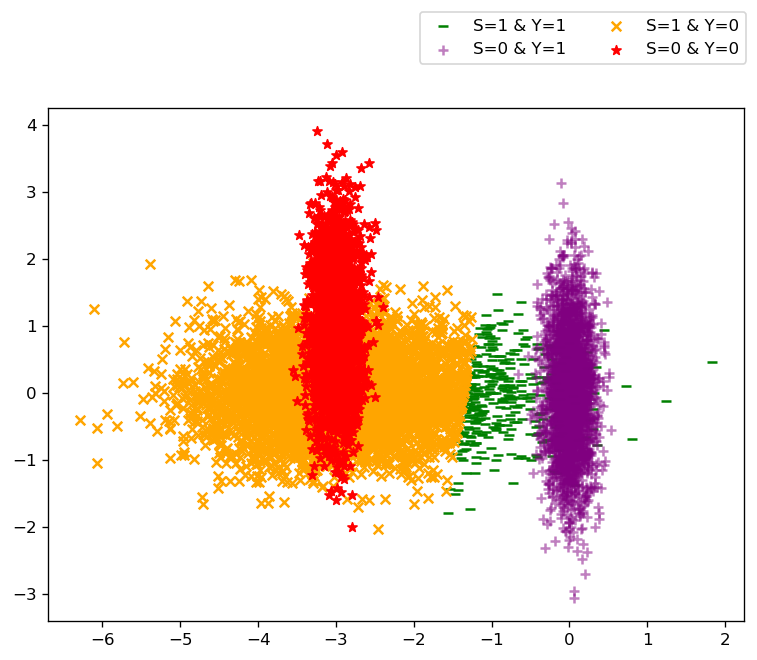

In [631]:
plot(Xt, yt, St)
model = LogisticRegression()

features_train = np.hstack([X, S.reshape(-1, 1)])
features_test = np.hstack([Xt, St.reshape(-1, 1)])
model.fit(features_train, y)

y_pred = model.predict(features_test)
y_prob = model.predict_proba(features_test)[:, 1]

acc = np.mean(y_pred == yt)
deo = empirical_unfairness(yt, y_pred, St)
print(f'ACC = {acc}   |   DEO = {deo}')
plot(Xt, y_pred, St)


In [632]:
features_unlabeled = np.hstack([Xt, St.reshape(-1, 1)])
y_pred = model.predict(features_unlabeled)
y_prob = model.predict_proba(features_unlabeled)[:, 1]

In [633]:
predicted_fairness = empirical_unfairness(yt, y_pred, St)

In [634]:
predicted_fairness

0.5237113402061856

In [635]:
theta, value, y_calib = recalibrate_predictions(y_pred, y_prob, St, max_iter=100)

In [636]:
f'Proportion of 0\'s in the prediction: {100 * np.sum(1-y_calib) / len(y_calib)} %'

"Proportion of 0's in the prediction: 69.57 %"

In [637]:
calibrated_fairness = empirical_unfairness(yt, y_calib, St)

In [638]:
calibrated_fairness

0.41030927835051545

In [639]:
calibrated_accuracy = np.mean(yt == y_calib)

In [640]:
calibrated_accuracy

0.9523

In [641]:
calibrated_accuracy >= acc

False

In [642]:
calibrated_fairness < predicted_fairness

True

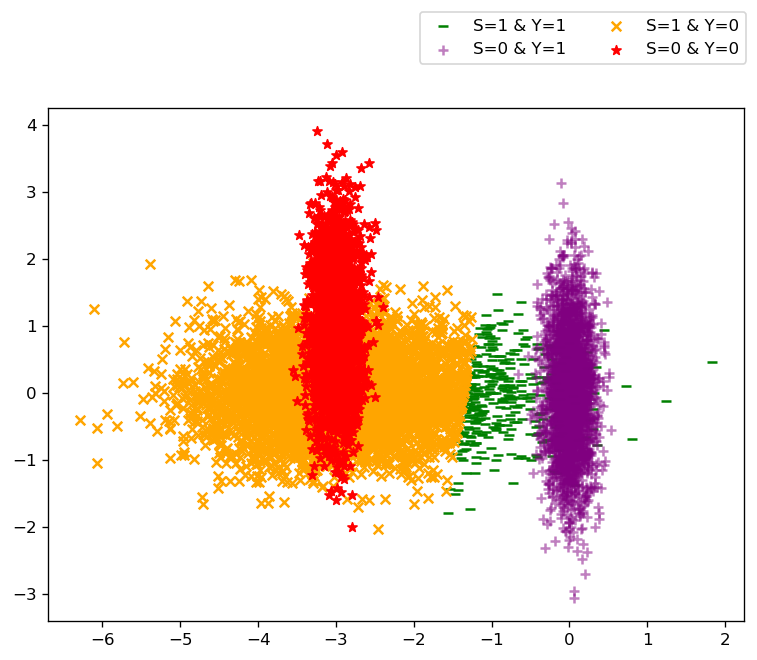

In [643]:
plot(Xt, y_pred, St)

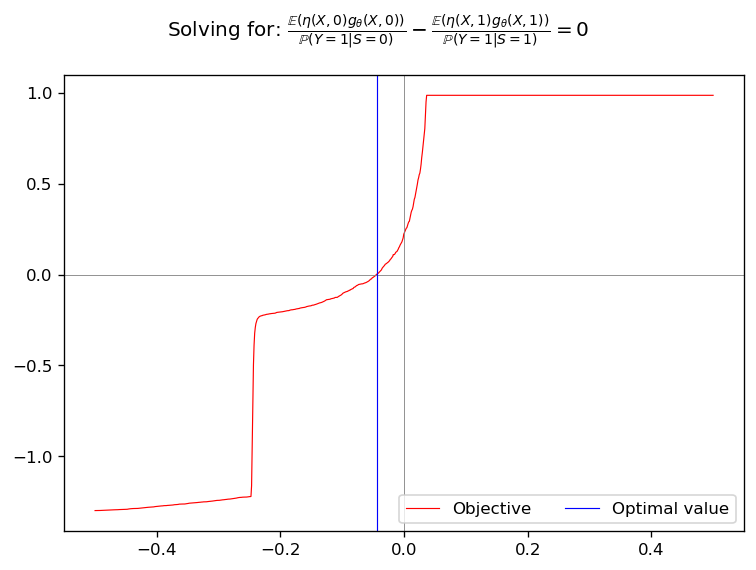

In [644]:
thetas = np.linspace(-.5, .5, 1000)
fig, ax = plt.subplots(dpi=120)
ax.plot(thetas, [objective(t, y_pred, y_prob, St) for t in thetas], color='red', label='Objective', lw=.7)
ax.axvline(0, color='gray', lw=.5)
ax.axhline(0, color='gray', lw=.5)
ax.axvline(theta, color='b', label='Optimal value', lw=.7)
fig.suptitle(r'Solving for: $\frac{\mathbb{E}(\eta(X, 0)g_{\theta}(X, 0))}{\mathbb{P}(Y=1|S=0)} - \frac{\mathbb{E}(\eta(X, 1)g_{\theta}(X, 1))}{\mathbb{P}(Y=1|S=1)} = 0$')
fig.tight_layout()
ax.legend(ncol=2);
fig.savefig('recalibration.png')
